# Set-up


In [33]:
import hydroDL.data.dbVeg
from hydroDL.data import dbVeg
import importlib
import numpy as np
import json
import os
from hydroDL import utils
from hydroDL.post import mapplot, axplot, figplot
import matplotlib.pyplot as plt
from hydroDL.model import rnn, crit, trainBasin
import math
import torch
from torch import nn
from hydroDL.data import DataModel
from hydroDL.master import basinFull, slurm, dataTs2Range
import torch.optim as optim
from hydroDL import kPath
import torch.optim.lr_scheduler as lr_scheduler
import dill
from tqdm import tqdm
import pandas as pd
import pickle

In [19]:
rho = 45 # init rho
dataName = 'singleDaily' # init dataName
importlib.reload(hydroDL.data.dbVeg) # reimport library
df = dbVeg.DataFrameVeg(dataName) # create DataFrameVeg class 

In [20]:
print(df.x.shape, df.xc.shape, df.y.shape)
# 1888: days, 335: sites

(1888, 335, 20) (335, 15) (1888, 335, 1)


In [21]:
dm = DataModel(X=df.x, XC=df.xc, Y=df.y) # (?) create DataModel class (contains many confusing functions) 
siteIdLst = df.siteIdLst # get site list
dm.trans(mtdDefault='minmax') # (?) some sort of data normalization
dataTup = dm.getData() # get x, xc, y, and yc
dataEnd, (iInd, jInd) = dataTs2Range(dataTup, rho, returnInd=True) # get data into form (# LFMC, 91 day window, varX) 
x, xc, y, yc = dataEnd # data from dataTs2Range

In [22]:
iInd = np.array(iInd)
jInd = np.array(jInd)

In [23]:
print(iInd.shape, jInd.shape, x.shape, xc.shape, yc.shape)
# 10407: obs, 91: day window, 10235: ??

(10235,) (10235,) (91, 10235, 20) (10235, 15) (10235, 1)


In [24]:
# get indices of variables of interest
varS = ['VV', 'VH', 'vh_vv']
varL = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'ndvi', 'ndwi', 'nirv']
varM = ['Fpar', 'Lai']
iS = [df.varX.index(var) for var in varS]
iL = [df.varX.index(var) for var in varL]
iM = [df.varX.index(var) for var in varM]

In [25]:
# for each satellite, for each LFMC data point
# create a list of days in the 91 day window that have data

# nMat -- (# obs, # satellites)
# nMat contains # of days each satellite has data for
pSLst, pLLst, pMLst = list(), list(), list()
ns = yc.shape[0]
nMat = np.zeros([yc.shape[0], 3])
for k in range(nMat.shape[0]):
    tempS = x[:, k, iS] # x (rho, LFMC, varX) 
    pS = np.where(~np.isnan(tempS).any(axis=1))[0]
    tempL = x[:, k, iL] # x (rho, LFMC, varX) 
    pL = np.where(~np.isnan(tempL).any(axis=1))[0]
    tempM = x[:, k, iM] # x (rho, LFMC, varX) 
    pM = np.where(~np.isnan(tempM).any(axis=1))[0]
    pSLst.append(pS)
    pLLst.append(pL)
    pMLst.append(pM)
    nMat[k, :] = [len(pS), len(pL), len(pM)]

In [26]:
# only keep data if there is at least 1 day of data for 
# each satellite
indKeep = np.where((nMat > 0).all(axis=1))[0]
x = x[:, indKeep, :]
xc = xc[indKeep, :]
yc = yc[indKeep, :]
nMat = nMat[indKeep, :]
pSLst = [pSLst[k] for k in indKeep]
pLLst = [pLLst[k] for k in indKeep]
pMLst = [pMLst[k] for k in indKeep]
jInd = jInd[indKeep] 

# update from just list of sites to sites per datapoint
siteIdLst = [siteIdLst[k] for k in jInd] 

In [27]:
jSite, count = np.unique(jInd, return_counts=True) # sites, # of times site appears
countAry = np.array([[x, y] for y, x in sorted(zip(count, jSite))]) # rearrange

# Modify threshold

In [39]:
THRESHOLD = 30
nRm = sum(countAry[:, 1] < THRESHOLD)
indSiteOverThresh = countAry[nRm:, 0].astype(int) 
indSiteUnderThresh = countAry[:nRm, 0].astype(int) 

dictSubset = dict()

dictSubset['testSite_underThresh'] = indSiteUnderThresh.tolist()
dictSubset['testInd_underThresh'] = np.where(np.isin(jInd, indSiteUnderThresh))[0].tolist()
for k in range(5):
    siteTest = indSiteOverThresh[k::5]
    siteTrain = np.setdiff1d(indSiteOverThresh, siteTest)
    indTest = np.where(np.isin(jInd, siteTest))[0]
    indTrain = np.where(np.isin(jInd, siteTrain))[0]
    dictSubset['testSite_k{}5'.format(k)] = siteTest.tolist()
    dictSubset['trainSite_k{}5'.format(k)] = siteTrain.tolist()
    dictSubset['testInd_k{}5'.format(k)] = indTest.tolist()
    dictSubset['trainInd_k{}5'.format(k)] = indTrain.tolist()

In [40]:
saveFolder = os.path.join(kPath.dirVeg, 'model', 'attention')
if not os.path.exists(saveFolder):
    os.mkdir(saveFolder)
dataFile = os.path.join(saveFolder, 'data.npz')
np.savez_compressed(dataFile, x=x, xc=xc, y=yc, yc=yc, tInd=iInd, siteInd=jInd)
subsetFile = os.path.join(saveFolder, 'subset.json')
with open(subsetFile, 'w') as fp:
    json.dump(dictSubset, fp, indent=4)

In [35]:
with open(os.path.join(kPath.dirVeg, 'threshold_dataset.pkl'), 'wb') as f: 
    pickle.dump(dictSubset, f)

In [13]:
len(N1)

159

In [14]:
len(N2)

151

In [15]:
N1_obs, N2_obs = 0, 0
for site in jInd:
    if site in N1: N1_obs += 1
    if site in N2: N2_obs += 1

In [16]:
N1_obs

7909

In [17]:
N2_obs

2061

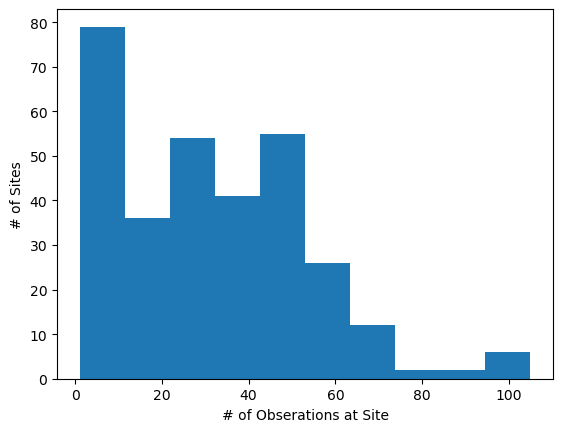

In [75]:
plt.hist(count)
plt.xlabel("# of Obserations at Site")
plt.ylabel("# of Sites")
plt.show()

In [76]:
iInd = iInd[indKeep]

In [77]:
site_min_diff = {}
for site in np.unique(jInd):
    if site not in N1:
        continue
    dates = iInd[jInd == site]
    min_diff = float("inf")
    for i in range(1, len(dates)):
        min_diff = min(min_diff, dates[i] - dates[i - 1])
    if min_diff == float("inf"):
        continue
    site_min_diff[site] = min_diff

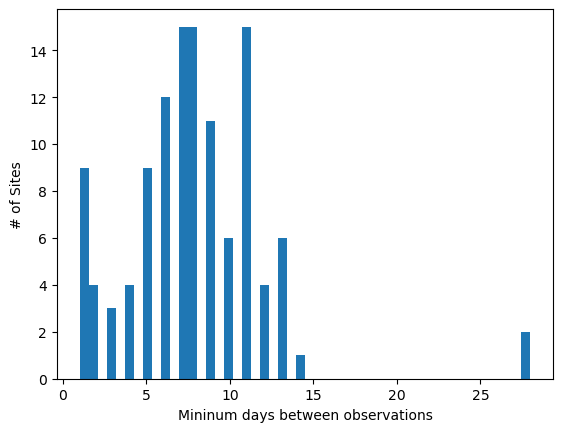

In [85]:
min_data = [min_diff for site, min_diff in site_min_diff.items()]
plt.hist(min_data, bins=50)
plt.xlabel("Mininum days between observations")
plt.ylabel("# of Sites")
plt.show()

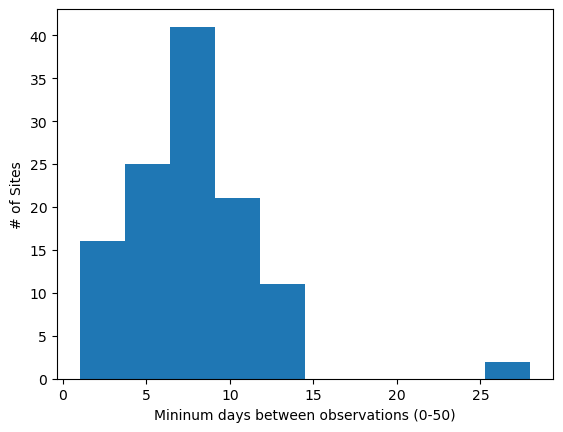

In [83]:
min_data_100 = []
for d in min_data:
    if d < 50:
        min_data_100.append(d)
plt.hist(min_data_100, bins=10)
plt.xlabel("Mininum days between observations (0-50)")
plt.ylabel("# of Sites")
plt.show()

In [86]:
site_med_diff = {}
for site in np.unique(jInd):
    if site not in N1:
        continue
    dates = iInd[jInd == site]
    diffs = []
    for i in range(1, len(dates)):
        diff = dates[i] - dates[i - 1]
        diffs.append(diff)
    site_med_diff[site] = np.median(diffs)

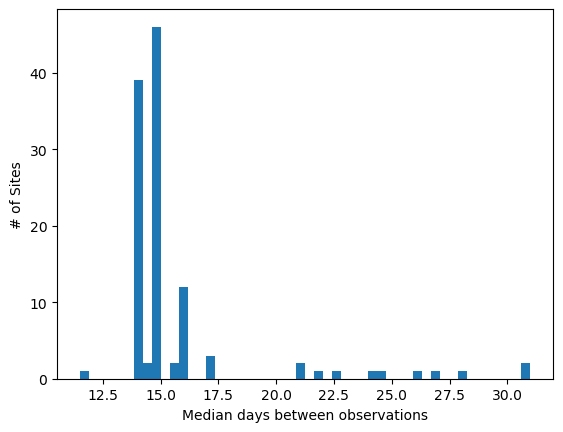

In [87]:
med_data = [med_diff for site, med_diff in site_med_diff.items()]
plt.hist(med_data, bins=50)
plt.xlabel("Median days between observations")
plt.ylabel("# of Sites")
plt.show()

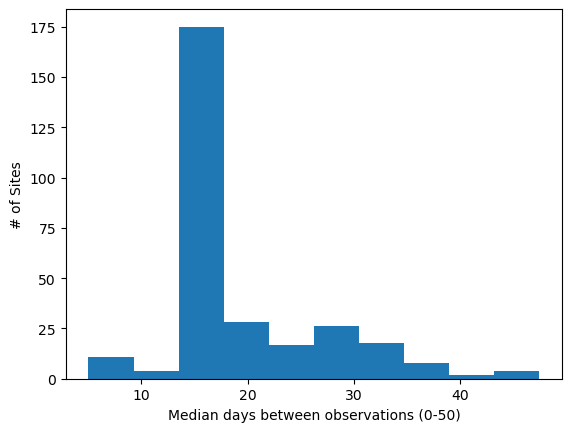

In [52]:
med_data_100 = []
for d in med_data:
    if d < 50:
        med_data_100.append(d)
plt.hist(med_data_100, bins=10)
plt.xlabel("Median days between observations (0-50)")
plt.ylabel("# of Sites")
plt.show()

In [110]:
site = np.random.choice(N2)
x = iInd[jInd == site]
y = yc[jInd == site]

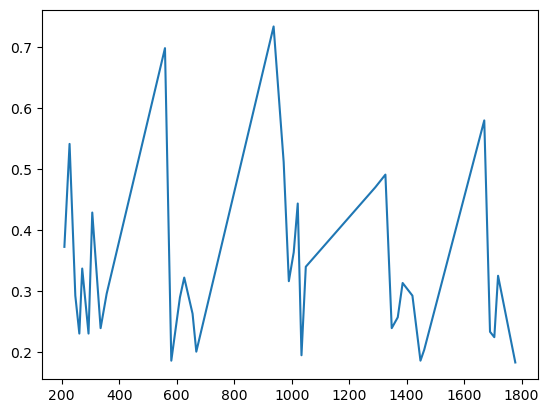

In [111]:
plt.plot(x, y)

In [101]:
sites_above_thresh = [df.siteIdLst[i] for i in N1]
sites_below_thresh = [df.siteIdLst[i] for i in N2]

In [ ]:
outFile = '/Users/andyhuynh/Documents/lfmc/providedData/NFMD/NFMD.csv'
# outFile = os.path.join(kPath.dirVeg, 'NFMD', 'NFMD.csv')
tabAll = pd.read_csv(outFile)
tabAll['Date'] = pd.to_datetime(tabAll['Date'], format='%Y-%m-%d')
crdFile = os.path.join(kPath.dirVeg, 'NFMD', 'NFMDsite.csv')
tabCrd = pd.read_csv(crdFile, index_col=0)

In [ ]:
tabAll[tabAll["siteId"].isin(siteSingle)]

In [ ]:
# find sites that are of single fuel
cntFuel = tabAll.groupby(['siteId'])['Fuel'].nunique().sort_values()
siteSingle = cntFuel[cntFuel == 1].index.tolist()
siteMix = cntFuel[cntFuel > 1].index.tolist()

In [ ]:
dict = {}
for site in siteSingle:
    tab = tabAll[tabAll['siteId'] == site]
    dates = tab.Date.tolist()
    dict[site] = len(dates)

In [ ]:
site = siteSingle[0]
tab = tabAll[tabAll['siteId'] == site]
dates = tab.Date.tolist()
print(site)
print(len(dates))

In [ ]:
jSite

In [ ]:
98 in count

In [ ]:
dict = {}
# loop thru each site
for site in siteSingle:
    tab = tabAll[tabAll['siteId'] == site]
    dates = tab.Date.tolist()
    # determine the min date diff and store in dictionary
    min_date_diff = float("inf")
    for i in range(len(dates)):
        for j in range(i + 1, len(dates)):
            date_diff = (dates[i] - dates[j]).days
            if date_diff < min_date_diff:
                min_date_diff = date_diff
    if min_date_diff == float("inf"):
        continue
    dict[site] = min_date_diff

In [ ]:
dists_above_thresh = []
for site, min_dist in dict.items():
    if site in sites_above_thresh:
        dists_above_thresh.append(min_dist)

In [ ]:
plt.hist(dists_above_thresh)
plt.xlabel("Minimum days between observations")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
dists_below_thresh = []
for site, min_dist in dict.items():
    if site in sites_below_thresh:
        dists_below_thresh.append(min_dist)

In [ ]:
plt.hist(dists_below_thresh)
plt.xlabel("Minimum days between observations")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
dict = {}
# loop thru each site
for site in siteSingle:
    tab = tabAll[tabAll['siteId'] == site]
    dates = tab.Date.tolist()
    # determine the min date diff and store in dictionary
    days_diff = []
    for i in range(len(dates)):
        for j in range(i + 1, len(dates)):
            days = (dates[i] - dates[j]).days
            days_diff.append(days)
    dict[site] = np.median(days_diff)

In [ ]:
dists_above_thresh = []
for site, min_dist in dict.items():
    if site in sites_above_thresh:
        dists_above_thresh.append(min_dist)

In [ ]:
plt.hist(dists_above_thresh)
plt.xlabel("Median days between observations")
plt.ylabel("# of Sites")
plt.show()

In [ ]:
dists_above_thresh = []
for site, min_dist in dict.items():
    if site in sites_above_thresh:
        dists_above_thresh.append(min_dist)

In [ ]:
plt.hist(dists_below_thresh)
plt.xlabel("Median days between observations")
plt.ylabel("# of Sites")
plt.show()